In [1]:
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy.stats import describe
from sklearn.model_selection import GridSearchCV, train_test_split, ParameterGrid
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.base import clone
from matplotlib import pyplot as plt
from matplotlib import cm

%matplotlib notebook

In [2]:
# Import the data
X = pd.read_csv('data/training_templates.csv', header=None)[::3]
y = np.loadtxt('data/training_labels.txt', dtype=np.int)[::3]
X_pred = pd.read_csv('data/testing_templates.csv', header=None)

## First, let us look at the data

In [3]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,35200.000000,35200.000000,35200.000000,35200.000000,35200.000000,35200.000000,35200.000000,35200.000000,35200.000000,35200.000000,...,35200.000000,35200.000000,35200.000000,35200.000000,35200.000000,35200.000000,35200.000000,35200.000000,35200.000000,35200.000000
mean,0.002523,0.009700,0.003310,-0.002191,-0.005524,0.006061,-0.001244,-0.000061,0.003478,0.026892,...,-0.008120,0.001058,0.013081,0.004022,-0.007558,-0.009282,-0.004423,0.018015,0.003418,0.011693
std,0.088225,0.088671,0.085494,0.088360,0.088884,0.087704,0.087736,0.087109,0.088867,0.087090,...,0.088689,0.086415,0.088939,0.087395,0.089930,0.085735,0.086920,0.086320,0.088043,0.088003
min,-0.374050,-0.340790,-0.325980,-0.334223,-0.354434,-0.337349,-0.346995,-0.356012,-0.337267,-0.310201,...,-0.389960,-0.305613,-0.330181,-0.363706,-0.359000,-0.339575,-0.320310,-0.342626,-0.302851,-0.325948
25%,-0.057239,-0.051015,-0.054807,-0.062969,-0.066523,-0.054080,-0.061494,-0.059307,-0.057645,-0.032961,...,-0.068380,-0.058909,-0.047447,-0.054860,-0.069134,-0.067983,-0.064687,-0.040507,-0.056636,-0.048704
50%,0.002514,0.010407,0.002810,-0.003308,-0.004822,0.006687,-0.001709,0.000004,0.003243,0.027749,...,-0.007426,0.000515,0.013556,0.005147,-0.007375,-0.009721,-0.005270,0.016729,0.004743,0.012180
75%,0.062201,0.071064,0.061427,0.057378,0.056212,0.065696,0.058495,0.059969,0.063107,0.087219,...,0.052748,0.060022,0.074094,0.063852,0.054667,0.049344,0.054312,0.076460,0.063899,0.072418
max,0.371896,0.336036,0.343744,0.316638,0.383177,0.383389,0.363600,0.339465,0.322913,0.404551,...,0.314785,0.368760,0.346131,0.320851,0.330347,0.313186,0.329378,0.357781,0.315059,0.349935


In [4]:
for col in X:
    desc = describe(X[col])
    print('{:3} - skewness: {:+1.5f}\tkurtosis: {:1.5f}\n'.format(col, desc.skewness, desc.kurtosis))

  0 - skewness: +0.00105	kurtosis: -0.04903

  1 - skewness: -0.04959	kurtosis: -0.15755

  2 - skewness: +0.02973	kurtosis: -0.07803

  3 - skewness: +0.04825	kurtosis: -0.09364

  4 - skewness: -0.03564	kurtosis: -0.15679

  5 - skewness: -0.00102	kurtosis: -0.10078

  6 - skewness: +0.04189	kurtosis: -0.08581

  7 - skewness: -0.03129	kurtosis: -0.07210

  8 - skewness: +0.00565	kurtosis: -0.10491

  9 - skewness: -0.04453	kurtosis: -0.16223

 10 - skewness: +0.00160	kurtosis: -0.10786

 11 - skewness: +0.00452	kurtosis: -0.04900

 12 - skewness: -0.03367	kurtosis: -0.13197

 13 - skewness: +0.04464	kurtosis: -0.13588

 14 - skewness: -0.00885	kurtosis: -0.15758

 15 - skewness: +0.02806	kurtosis: -0.09091

 16 - skewness: +0.03011	kurtosis: -0.11783

 17 - skewness: -0.02255	kurtosis: -0.01728

 18 - skewness: -0.06496	kurtosis: -0.00254

 19 - skewness: +0.11425	kurtosis: -0.05783

 20 - skewness: +0.00981	kurtosis: -0.08543

 21 - skewness: +0.00615	kurtosis: -0.11846

 22 - skew

<IPython.core.display.Javascript object>


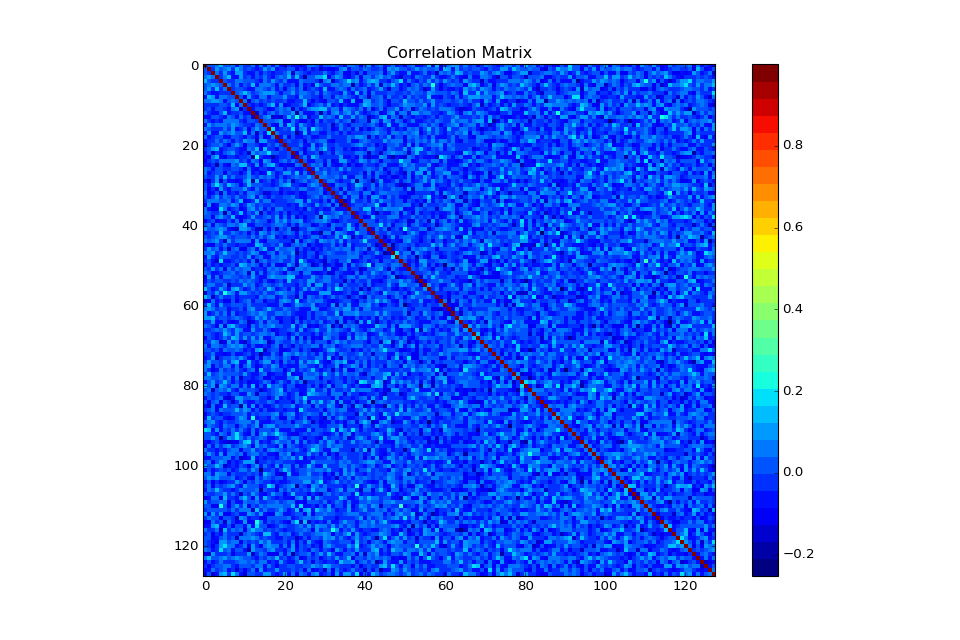

In [5]:
fig = plt.figure(figsize=(12, 8))
cmap = cm.get_cmap('jet', 30)
correlations_X = X.corr()
cax = plt.imshow(correlations_X, interpolation="nearest", cmap=cmap)
plt.title('Correlation Matrix')
cbar = fig.colorbar(cax, ticks=np.arange(-1., 1., 0.2))
plt.show()

### Il ne semble pas y avoir de corrélation prononcée entres les variables, tout porte à croire qu'elles sont indépendantes

In [6]:
n, p = X.shape
print('La plus forte corrélation entre 2 variables explicatives est de:')
np.max([abs(correlations_X.loc[i, j]) for i in range(p) for j in range(i)])

La plus forte corrélation entre 2 variables explicatives est de:


0.27349652572212468

<IPython.core.display.Javascript object>


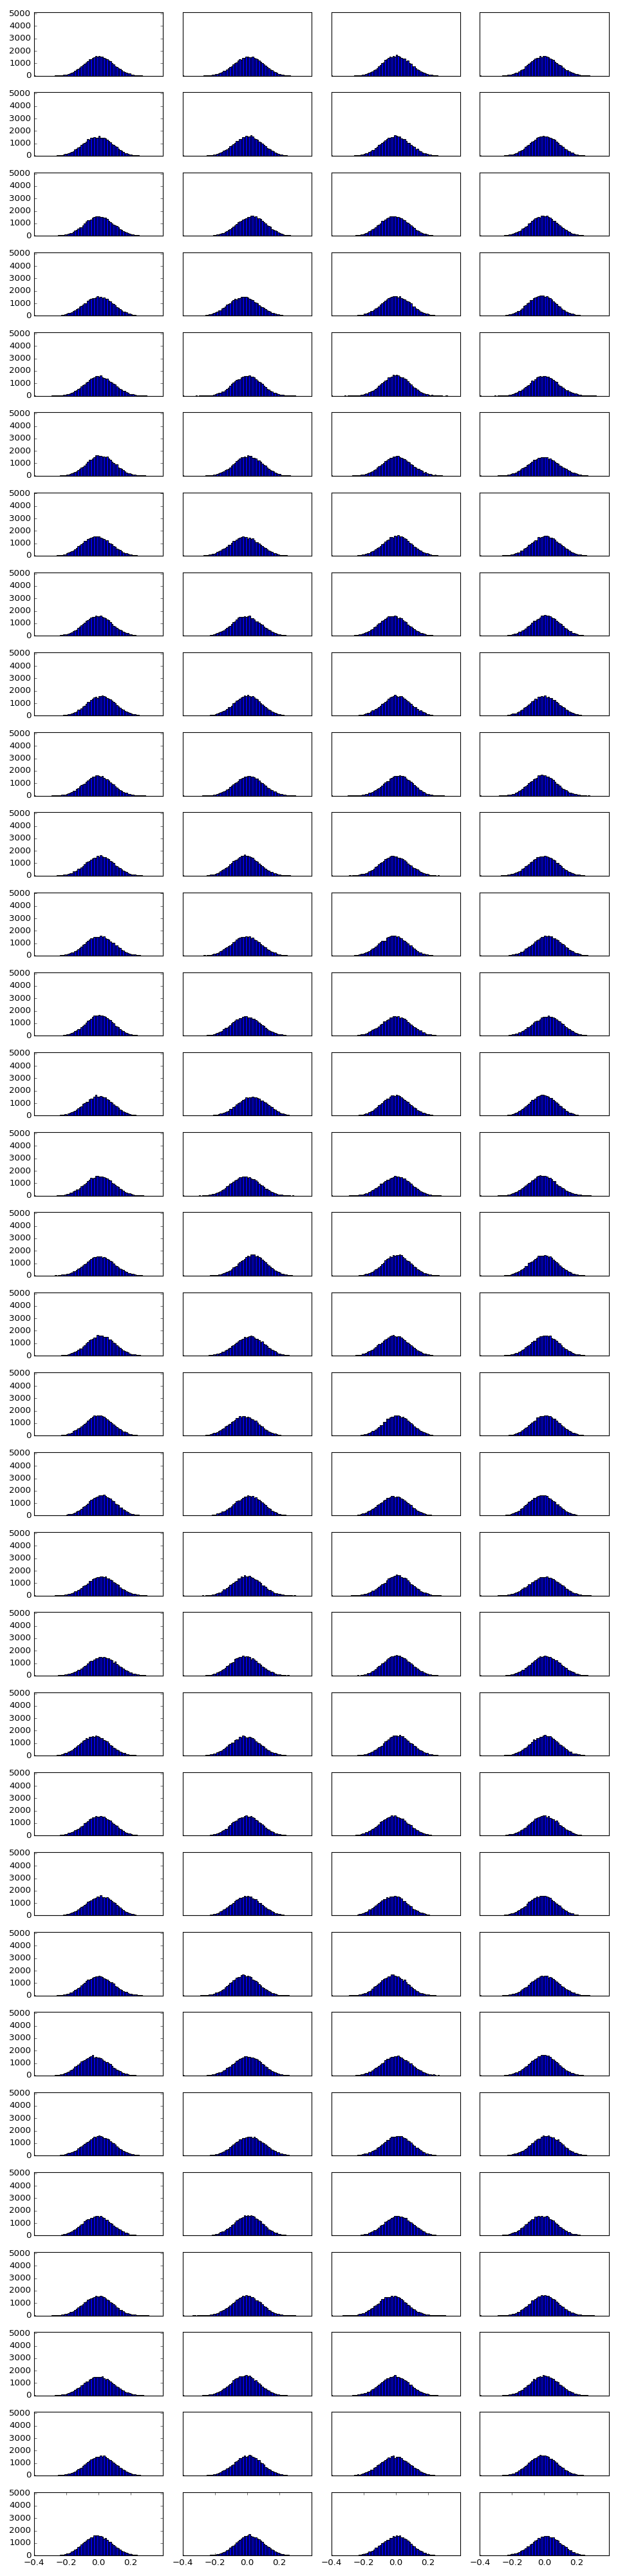

In [7]:
plt.figure(figsize=(12, 50))
for i, col in enumerate(X):
    plt.subplot(32, 4, i+1)
    plt.xticks([] if i < 124 else np.arange(-.4, .4, .2))
    plt.yticks([] if i%4!=0 else np.arange(0, 5100, 1000))
    plt.ylim(ymin=0, ymax=5100)
    plt.xlim(xmin=-0.4, xmax=0.4)
    plt.hist(X[col], bins=np.arange(-0.4, 0.4, 0.01))

plt.tight_layout()

Les kurtosis calculées précédemment semblaient indiquer des gaussiennes, ces histogrammes nous le confirment.

## Etude de y

In [8]:
for v in np.unique(y):
    print('Number of', v, ':', np.sum(y==v))

Number of -1 : 17600
Number of 1 : 17600


Pour y, l'étude est rapide et montre que nous avons autant d'hommes que de femmes dans l'échantillon.

## Étude d'un premier classifieur: LinearSVC

Ce point de départ n'est pas innocent. Il est guidé par la documentation de scikit-learn, qui donne des indications quant aux algorithmes à employer selon le type de prediction que l'on veut faire (homme/femme -> catégorie), la quantité d'échantillon d'entraînement et le type de données (cf. http://scikit-learn.org/stable/tutorial/machine_learning_map/).

Ayant initialement développé en Python et oublié de garder des copies fréquentes de mon travail (j'ai utilisé un unique fichier python que j'ai édité au fur et à mesure), le présent rapport est une version simplifiée de mes recherches. Il reproduit assez fidèlement le cheminement que j'ai suivi, je n'y utiliserai cependant pas de cross validation comme je l'ai fait dans le travail initial, mais un simple train/test split, par souci de temps de calcul. Les résultats sont sensiblement les même, seule la rigueur en patit.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

def scoring(clf, X, y):
    """
    Given a classifier and a test set, calculate the best threshold for the probability
    that indicates if a points should be labeled or not, and return the corresponding score.
    """
    pred_orig = clf.predict(X)
    probas = clf.predict_proba(X)

    best_score = 999.
    best_proba = 0.5
    for min_proba in np.arange(best_proba, 1., 0.01):
        pred = pred_orig
        indices = [i for i, p in enumerate(probas) if p[0] < min_proba and p[1] < min_proba]

        pred[indices] = 0
        score = compute_pred_score(y, pred)
        if score < best_score:
            best_proba = min_proba
            best_score = score
    return best_score


def score_clf(clf, params, scoring):
    clf_inst = clf(**params)
    clf_inst.fit(X_train, y_train)
    score = scoring(clf_inst, X_test, y_test)
    print('Score for params:', params, '\t', score)
    return score

def eval_clf(clf, grid, scoring=scoring):
    """
    Evaluate the classifier 'clf' on the grid, and return the 
    parameters that gives the best score.
    """
    args = [(clf, params, scoring) for params in grid]
    with Pool() as p:
        scores = p.starmap(score_clf, args)
    i = np.argmin(scores)
    return {'best_score': scores[i], 'best_params': args[i][1]}


# Define scoring methods
def compute_pred_score(y_true, y_pred):
    """
    One error costs 10, a line that remains unlabeled costs 1
    """
    y_comp = y_true * y_pred
    return float(10 * np.sum(y_comp == -1) + np.sum(y_comp == 0)) / y_comp.shape[0]

In [10]:
def scoring_linear_svc(clf, X, y):
    """
    Given a classifier and a test set, calculate the best threshold for the probability
    that indicates if a points should be labeled or not, and return the corresponding score.
    """
    pred_orig = clf.predict(X)
    probas = clf.decision_function(X)

    best_error = 999.
    best_proba = 0.5
    for min_proba in np.arange(best_proba, 1., 0.01):
        pred = pred_orig
        pred[probas <= min_proba] = 0
        error = compute_pred_score(y, pred)
        if error < best_error:
            best_proba = min_proba
            best_error = error
    
    # Maximizing the score <=> minimizing the error
    return best_error

In [11]:
C = np.logspace(-3, 1, 5)
params = ParameterGrid([
    {'C': C, 'loss': ['hinge', 'squared_hinge'], 'penalty': ['l2']}, 
    {'C': C, 'loss': ['squared_hinge'], 'penalty': ['l1'], 'dual': [False]}
])

eval_clf(LinearSVC, params, scoring=scoring_linear_svc)

Score for params: {'loss': 'hinge', 'C': 0.001, 'penalty': 'l2'} 	 0.9344318181818182
Score for params: {'loss': 'hinge', 'C': 0.01, 'penalty': 'l2'} 	 0.7473863636363637
Score for params: {'loss': 'squared_hinge', 'C': 0.01, 'penalty': 'l2'} 	 0.7232954545454545
Score for params: {'loss': 'squared_hinge', 'C': 0.10000000000000001, 'penalty': 'l2'} 	 0.6718181818181819
Score for params: {'loss': 'hinge', 'C': 0.10000000000000001, 'penalty': 'l2'} 	 0.69875
Score for params: {'loss': 'squared_hinge', 'C': 0.001, 'penalty': 'l2'} 	 0.9190909090909091
Score for params: {'loss': 'hinge', 'C': 1.0, 'penalty': 'l2'} 	 0.6689772727272727
Score for params: {'loss': 'squared_hinge', 'C': 0.001, 'penalty': 'l1', 'dual': False} 	 1.0
Score for params: {'loss': 'squared_hinge', 'C': 1.0, 'penalty': 'l2'} 	 0.6629545454545455
Score for params: {'loss': 'hinge', 'C': 10.0, 'penalty': 'l2'} 	 0.6744318181818182
Score for params: {'loss': 'squared_hinge', 'C': 0.01, 'penalty': 'l1', 'dual': False} 	 0

{'best_params': {'C': 1.0, 'loss': 'squared_hinge', 'penalty': 'l2'},
 'best_score': 0.6629545454545455}

On trouve un score légèrement meilleur que si l'on ne s'était pas prononcé sur les valeurs 

## Un deuxième classifieur: le KNN

Le classifieur précédent ayant donné des résultats médiocres, nous en essayons un autre: le KNN (sklearn.neighbors.KNeighborsClassifier).

In [12]:
def gaussian_weight(d):
    return np.exp(-d**2 / 0.1)

In [13]:
params = ParameterGrid({'n_neighbors': [23, 25, 27], 'weights': ['distance', gaussian_weight]})
eval_clf(KNeighborsClassifier, params)

Score for params: {'weights': <function gaussian_weight at 0x7f349f4a5ae8>, 'n_neighbors': 25} 	 0.11397727272727273
Score for params: {'weights': <function gaussian_weight at 0x7f349f4a5ae8>, 'n_neighbors': 27} 	 0.11272727272727273
Score for params: {'weights': <function gaussian_weight at 0x7f349f4a5ae8>, 'n_neighbors': 23} 	 0.11488636363636363
Score for params: {'weights': 'distance', 'n_neighbors': 25} 	 0.13397727272727272
Score for params: {'weights': 'distance', 'n_neighbors': 27} 	 0.1375
Score for params: {'weights': 'distance', 'n_neighbors': 23} 	 0.13545454545454547


{'best_params': {'n_neighbors': 27,
  'weights': <function __main__.gaussian_weight>},
 'best_score': 0.11272727272727273}

In [14]:
# Étude du résultat

## Le classifieur SVC

In [15]:
params = ParameterGrid([
    {'C': [100, 1000, 10000, 50000], 'probability': [True]},
])

eval_clf(SVC, params)

Score for params: {'C': 100, 'probability': True} 	 0.29613636363636364
Score for params: {'C': 1000, 'probability': True} 	 0.16261363636363638
Score for params: {'C': 10000, 'probability': True} 	 0.11238636363636363
Score for params: {'C': 50000, 'probability': True} 	 0.12840909090909092


{'best_params': {'C': 10000, 'probability': True},
 'best_score': 0.11238636363636363}

# Les classifieurs d'ensemble

## VotingClassifier

VotingClassifier permet de choisir la meilleur prédiction entre plusieurs classifieurs, dans le sens où il retourne la valeur prédite avec la plus grande probabilité.

In [16]:
estimators = [
    ('knn', KNeighborsClassifier(n_neighbors=25)),
    ('svc', SVC(C=50000, probability=True))
]

score_clf(VotingClassifier, {'estimators': estimators, 'voting': 'soft'}, scoring=scoring)

Score for params: {'estimators': [('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=25, p=2,
           weights='uniform')), ('svc', SVC(C=50000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))], 'voting': 'soft'} 	 0.10056818181818182


0.10056818181818182

### On voit que le fait de combiner les résultats des 2 classifieurs et de les pondérer par leur confiance en chaque point permet d'améliorer considérablement le résultat, en prenant "the best of both worlds".

# Travail sur les données

Nous avons déjà fait la remarque que les variables explicatives étaient difficilement interprétables ou différenciables, et vouloir en discriminer une par rapport à l'autre ne semble donc pas judicieux.
Un choix qui parait plus adapté dans notre cas particulier est de discriminer sur les lignes. En effet, les lignes, sans que nous sachions les détails, représentent chacune les caractéristiques d'un visage. Il n'est pas insensé de se dire que les personnes dont les caractéristiques faciales sont similaires ont de grandes chances d'être du même sexe. Nous allons donc déterminer un(des) plus proche(s) jumeau(x) pour chaque personne dont nous cherchons à deviner le sexe.

Remarque: cette démarche est ici adaptée dans le sens où nous connaissons déjà la population à prédire. Dans la vraie vie, il serait formellement déconseillé de procéder de la sorte, pour des soucis de généralisation du classifieur produit.

In [17]:
# Pour chaque point de X_pred, retourne la liste des indices des éléments de X 
# ordonné par distance croissante
distances = pairwise_distances_argmin(X_pred, X)

X2 = X.iloc[distances, :][:len(X_pred)]
y2 = y[distances][:len(X_pred)]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)

def score_clf2(clf, params, scoring):
    clf_inst = clf(**params).fit(X2_train, y2_train)
    score = scoring(clf_inst, X2_test, y2_test)
    print('Score for params:', params, '\t', score)
    return score

def eval_clf2(clf, grid, scoring=scoring):
    """
    Evaluate the classifier 'clf' on the grid, and return the 
    parameters that gives the best score.
    """
    args = [(clf, params, scoring) for params in grid]
    with Pool() as p:
        scores = p.starmap(score_clf2, args)
    i = np.argmin(scores)
    return {'best_score': scores[i], 'best_params': args[i][1]}

Cette configuration des données oblige à redéterminer les paramètres minimisant l'erreur pour chaque classifieur comme fait précédemment

In [18]:
params = ParameterGrid({'n_neighbors': np.arange(15, 20, 2), 'weights': [gaussian_weight]})
eval_clf2(KNeighborsClassifier, params)

Score for params: {'weights': <function gaussian_weight at 0x7f349f4a5ae8>, 'n_neighbors': 15} 	 0.1016949152542373
Score for params: {'weights': <function gaussian_weight at 0x7f349f4a5ae8>, 'n_neighbors': 17} 	 0.09463276836158192
Score for params: {'weights': <function gaussian_weight at 0x7f349f4a5ae8>, 'n_neighbors': 19} 	 0.09274952919020715


{'best_params': {'n_neighbors': 19,
  'weights': <function __main__.gaussian_weight>},
 'best_score': 0.09274952919020715}

In [19]:
params = ParameterGrid([
    {'C': [1000, 10000, 50000], 'probability': [True], 'kernel': ['rbf']},
])

eval_clf2(SVC, params)

Score for params: {'C': 1000, 'probability': True, 'kernel': 'rbf'} 	 0.18926553672316385
Score for params: {'C': 10000, 'probability': True, 'kernel': 'rbf'} 	 0.0903954802259887
Score for params: {'C': 50000, 'probability': True, 'kernel': 'rbf'} 	 0.0847457627118644


{'best_params': {'C': 50000, 'kernel': 'rbf', 'probability': True},
 'best_score': 0.0847457627118644}

## Essai d'un nouveau classifieur: MLPClassifier

In [20]:
params = ParameterGrid({'hidden_layer_sizes': [(100,), (200,), (300,)]})
eval_clf2(MLPClassifier, params)

Score for params: {'hidden_layer_sizes': (200,)} 	 0.08239171374764595
Score for params: {'hidden_layer_sizes': (100,)} 	 0.08851224105461393
Score for params: {'hidden_layer_sizes': (300,)} 	 0.07156308851224105


{'best_params': {'hidden_layer_sizes': (300,)},
 'best_score': 0.07156308851224105}

In [21]:
estimators = [
    ('knn', KNeighborsClassifier(n_neighbors=17)),
    ('svc', SVC(C=50000, probability=True)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(200,)))
]

score_clf2(VotingClassifier, {'estimators': estimators, 'voting': 'soft', 'n_jobs': -1}, scoring=scoring)

Score for params: {'estimators': [('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='uniform')), ('svc', SVC(C=50000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('mlp', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))], 'voting': 'soft', 'n_jobs': -1} 	 0.08333333333333333


0.08333333333333333

# Combinaison des résultats précédents

Nous avons mis en évidence plusieurs faits:
 - l'union fait la force: le fait de comparer la prédiction de différents classifieurs et de choisir celle pour laquelle la certitude exprimée est la plus forte a été bénéfique
 - DANS CET EXERCICE où le jeu de données à prédire est connu, le fait de "spécialiser" notre classifieur en le nourrissant de données proches de celles qu'ils va devoir prédire améliore ses performances
 - on remarque qu'il est régulièrement inutile de prendre des configurations exotiques pour les classifieurs, les configurations par défaut étant souvent bien calibrées. Il suffit ensuite de déterminer la valeur optimale pour un voire deux paramètres, en fonction des données mais aussi parfois du matériel de calcul
 
On construit alors l'algorithme de prédiction complet suivant:

In [1]:
clf = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
clf.fit(X2_train, y2_train)

pred_orig = clf.predict(X2_test)
probas_train = clf.predict_proba(X2_test)

best_proba = 0
min_error = 999
for min_proba in np.arange(0.6, 1., 0.001):
    pred = pred_orig
    indices = [i for i, p in enumerate(probas_train) if p[0] <= min_proba and p[1] <= min_proba]
    pred[indices] = 0

    error = compute_pred_score(y2_test, pred)
    if error <= min_error:
        best_proba = min_proba
        min_error = error

print(best_proba)
print(min_error)

clf.fit(X2, y2)
probas_test = clf.predict_proba(X_pred)

indices = [i for i, p in enumerate(probas_test) if p[0] < best_proba and p[1] < best_proba]
print('Predictions that are to be set to 0:', len(indices))

y_pred = clf.predict(X_pred)
y_pred[indices] = 0
np.savetxt('y_pred.txt', y_pred, fmt='%d')

NameError: name 'KNeighborsClassifier' is not defined